# 机器学习期末大作业
#### 小组成员及贡献：
- 任薏霖`2011897`：第一问部分代码，第二问部分推导
- 李彦泽`2012009`：第一问部分代码，第三问部分代码
- 姜志凯`2011937`：第二问部分推导，第三问部分代码

### 初级要求-利用tensorflow构建一个VAE

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt

In [3]:
# 读取手写字体样本集
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [4]:
# 重整为：样本数x宽x高x色深 的格式
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

In [5]:
# 规范化数据到0-1浮点
train_images /= 255.
test_images /= 255.

# 将数据二值化，背景是0，笔画是1
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

In [6]:
TRAIN_BUF = 60000
BATCH_SIZE = 100
TEST_BUF = 10000

# 这里需要注意一下批次数量是100
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [7]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                # 均值和对数方差的长度都是latent_dim，所以这里是两个
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        # 生成模型，相当于Decoder，使用编码生成对应的手写数字图片
        self.generative_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64,
                    kernel_size=3,
                    strides=(2, 2),
                    padding="SAME",
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32,
                    kernel_size=3,
                    strides=(2, 2),
                    padding="SAME",
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
            ]
        )
    # 获取一百幅样本图片
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    # 编码器
    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        self.mean = mean
        self.logvar = logvar
        return mean, logvar

    # 在向量空间内均匀分布生成100个随机编码
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        # tf.exp  is e^(logvar*0.5)
        return eps * tf.exp(logvar * .5) + mean

    # 解码器
    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs

        return logits

In [8]:
optimizer = tf.keras.optimizers.Adam(1e-4)

In [9]:
# 代价函数
def compute_loss(model, x):
    # 编码一个批次（100）的图片
    mean, logvar = model.encode(x)
    # 随机生成100个均匀分布的编码向量
    z = model.reparameterize(mean, logvar)
    # 使用编码向量生成图片
    x_logit = model.decode(z)
    # 计算交叉熵损失
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    marginal_likelihood = - tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    marginal_likelihood = tf.reduce_mean(marginal_likelihood)

    KL_divergence = tf.reduce_sum(mean ** 2 + tf.exp(logvar) - logvar - 1, axis=1)
    KL_divergence = tf.reduce_mean(KL_divergence)
    
    #计算L2_loss
    #loss = tf.losses.mean_squared_error(x_logit,x)
    #return KL_divergence+loss
    return KL_divergence - marginal_likelihood 

In [10]:
# 进行一次训练和梯度迭代
def compute_gradients(model, x):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    return tape.gradient(loss, model.trainable_variables), loss

In [11]:
# 根据梯度下降计算的结果，调整模型的权重值
def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))

In [12]:
# 训练迭代100次
epochs = 100
# 编码向量的维度
latent_dim = 50
# 用于生成图片的样本数，4格x4格共16幅
num_examples_to_generate = 16

In [13]:
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
# 模型实例化
model = CVAE(latent_dim)

In [14]:
# 产生一幅图片
def generate_and_save_images(model, epoch, test_input):
    # 生成16幅样本图片
    predictions = model.sample(test_input)
    # 4格*4格图片
    fig = plt.figure(figsize=(4, 4))

    # for i in range(predictions.shape[0]):
    # 用样本中的前16幅生成一张4x4排布的汇总图片
    for i in range(4*4):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.show()
    plt.close()

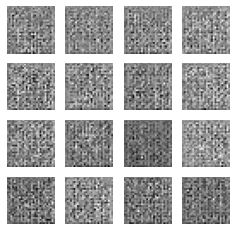

In [15]:
# 先生成第一幅、未经训练情况下的样本图片，所有的手写字符都还在随机噪点状态
generate_and_save_images(model, 0, random_vector_for_generation)

Epoch: 20, Test set ELBO: -112.97052001953125, time elapse for current epoch 45.97102737426758


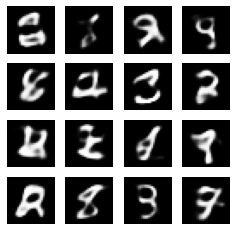

Epoch: 40, Test set ELBO: -108.24745178222656, time elapse for current epoch 45.90096426010132


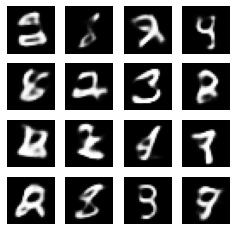

Epoch: 60, Test set ELBO: -106.46328735351562, time elapse for current epoch 45.294278621673584


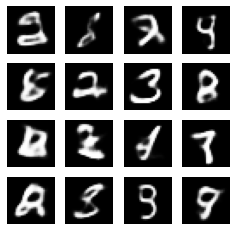

Epoch: 80, Test set ELBO: -104.90064239501953, time elapse for current epoch 48.207223415374756


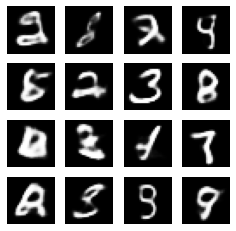

Epoch: 100, Test set ELBO: -104.02847290039062, time elapse for current epoch 45.278639793395996


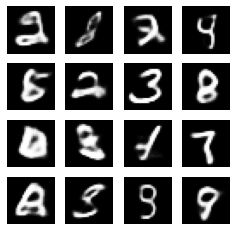

In [16]:
# 训练循环
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        # 训练一个批次
        gradients, loss = compute_gradients(model, train_x)
        apply_gradients(optimizer, gradients, model.trainable_variables)
    end_time = time.time()

    # 在每个迭代循环生成一张图片和显示一次模型信息
    if epoch % 20 == 0:
        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            loss(compute_loss(model, test_x))
        elbo = -loss.result()
        # 显示迭代次数、损失值、和本次迭代循环耗时
        print("============================")
        print(
            'Epoch: {}, Test set ELBO: {}, '
            'time elapse for current epoch {}'.format(
                epoch,
                elbo,
                end_time - start_time))
        # 生成一张图片保存起来
        generate_and_save_images(
            model, epoch, random_vector_for_generation)

#### 使用MSE_loss迭代100次得到的图片如下：

![result](8.PNG)

### 中级要求-介绍VAE由来、优缺点，推导VAE变分推断

#### 介绍VAE
VAE的前身AE：通过自监督的训练方式，能够从原始特征获得一个潜在的特征编码，实现了自动化的特征工程，并且达到了降维和泛化的目的，它的网络结构很简单，由编码和解码两个部分组成，AE的重点在于编码，即得到隐藏层的向量；解码的结果，基于训练目标，如果损失足够小的话，将会与input相同。AE模型在从输入到输出的整个过程中，都是基于已有训练数据的映射，隐藏层的概率分布只取决于训练数据的分布，从而导致隐藏状态空间的分布并不是连续的

VAE的基本思路：将真实样本通过编码器网络变换成理想数据分布，数据分布再传递给解码器网络从而得到生成样本，生成样本与真实样本足够接近时，则训练出自编码器模型。而VAE在自编码器的基础上进行变分处理，使得编码器的输出结果能对应到目标分布的均值和方差。VAE将经过神经网络编码后的隐藏层假设为一个标准的高斯分布，然后再从这个分布中采样一个特征，再用这个特征进行解码，期望得到与原始输入相同的结果，损失和AE几乎一样，只是增加编码推断分布与标准高斯分布的KL散度的正则项，从而防止模型退化成普通的AE。在VAE中，为了给编码添加合适的噪音，编码器会输出两个编码，一个是原有编码 $(m1,m2,m3)$，另外一个是控制噪音干扰程度的编码 $(σ1,σ2,σ3)$，第二个编码是为随机噪音码分配权重 $(e1,e2,e3)$，然后加上 $ exp(σi)$ 的目的是为了保证这个分配的权重是个正值，最后将原编码与噪音编码相加，就得到了VAE在 $code$ 层的输出结果 $ (ci)$;

#### 变分推导
##### VAE：将AE的编码与解码过程转化为贝叶斯概率模型
隐向量 $z$ 从先验分布 $p (z)$ 中采样得到，然后数据点 $x$ 从以 $z$ 为条件的分布 $p (x|z)$ 中产生。
因此生成观测变量过程便是似然分布（也就是解码器）：$p(x|z)$； 因而编码器是后验分布：$p(z|x) $ </p>
<br> 整个模型定义了数据和隐向量的联合分布 $p (x,z)=p (x|z) p (z)$
######  VAE变分推导依赖数学公式
* 贝叶斯公式
$$p(z|x)=\frac{p(x|z)p(z)}{p(x)}  $$ 
* 边缘概率公式
$$p(x)=\int_z^{}{p(z|x)\rm d}z  $$
* KL散度公式
$$KL(p||q))=\int^{}{p(x)log\frac{p(x)}{q(x)}\rm d}x$$

###### 具体推导
根据贝叶斯公式,建立先验、后验和似然的关系：
<br>
*  公式（1）$$p(z|x)=\frac{p(x|z)p(z)}{p(x)}=\int_{z}^{}{\frac{p(x|z)p(z)}{p(x)}\rm d}z   $$ 
由于上述公式中，等号右边积分内的$p(x)$与$z$无关，$p(x)$可以单独提取出

* 公式（2）$$p(x)=p(x)\int_z^{}{p(z|x)\rm d}z  $$
而$\int_z^{}{p(z|x)\rm d}z=1$ 故对两边取 $log$，可得：

* 公式（3）
$$logp(x)=logp(x)\int_z^{}{p(z|x)\rm d}z  $$
由于$logp(x)$与z无关，我们可以把$logp(x)$放回到积分中去，得到:

* 公式（4）
$$logp(x)=\int_z^{}{p(z|x)logp(x)\rm d}z  $$
由于无法计算 $p(X)$ ，进而无法直接解出 $p(z|X)$ ,由此提出采用 $q(z|X)$ 近似$p(z|X)$。由于任意分布都可以用若干个高斯分布进行拟合，因此 VAE 假设 $q(z|X)$ 服从高斯分布，即 $$q(z|X)∼N(μ,\sigma^2)$$ 

* 公式（5）
$$logp(x)=logp(x)\int_z^{}{q(z|x)d}z=\int_z^{}{q(z|x)*logp(x)d}z$$

* 公式（6）
$$logp(x)=log\frac{p(x,z)}{p(z|x)}=logp(x,z)-logp(z|x)=log\frac{p(x,z)}{q(z|x)}-log\frac{p(z|x)}{q(z|x)}$$
同时对上述公式两侧乘以 $q(z|x)$ 并取积分得：

* 公式（7）
$$logp(x)=\int_z^{}{q(z|x)log\frac{p(x,z)}{p(z|x)}\rm d}z-\int_z^{}{q(z|x)log\frac{p(z|x)}{q(z|x)}\rm d}z$$
利用KL散度公式，根据公式（7）可推导出：

* 公式（8）
$$logp(x)=KL(q(z|x)||p(z|x))+\int_z^{}{q(z|x)log\frac{p(x|z)p(z)}{q(z|x)}\rm d}z$$

* 公式（9）
$$logp(x)=KL(q(z|x)||p(z|x))+\int_z^{}{q(z|x)logp(x|z)\rm d}z+\int_z^{}{q(z|x)log\frac{p(z)}{q(z|x)}\rm d}z$$

* 公式（10）
$$logp(x)=KL(q(z|x)||p(z|x))+E_{z ~ q(z|x)}[logp(x|z)]-KL(q(z|x)||p(z))$$

* 公式（11）
$$ ELBO=-KL(q(z|x)||p(z))+E_{z ~ q(z|x)}[logp(x|z)]$$
当样本数为n时，重构损失项为：

* 公式(12)
$$E_q[logp(x|z)]=\frac{1}{n}\sum_{i=0}^{n}{logp(x_i|z_i)}$$
改变 $q(z)$ 并不能影响 $logp(x)$ 的大小，而且$ logp(x)$ 大于 $ELBO$，那么欲似然  $logp(x)$ 更大，可从 $ELBO$ 下手，最大化 $ELBO$ 可以导出最大化 $logp(x)$ 
###### 进一步推导ELBO
VAE 假设 $q(z|X)$ 服从高斯分布，即 $q(z|X)∼N(μ,\sigma^2)$ 

* 公式（13）
$$ KL(q(z|x)||p(z))=KL(N(μ,\sigma^2))||N(0,1))$$
$$ =\int_{z}^{}{{\frac{1}{\sqrt{2\pi\sigma^2}}}[exp-{\frac{(z-\mu)^2}{2{\mu}^2}}][log(\frac{\frac{1}{\sqrt{2\pi\sigma^2}}exp(-\frac{(z-\mu)^2}{2\sigma^2})}{\frac{1}{\sqrt{2\pi}}exp(-\frac{z^2}{2})})]\rm d}z$$
$$=\int_{z}^{}{{\frac{1}{\sqrt{2\pi\sigma^2}}}exp{\frac{-(z-\mu)^2}{2{\sigma}^2}}log({{\frac{1}{\sqrt{\sigma^2}}}exp{\frac{1}{2}}[x^2-{\frac{(z-\mu)^2}{\sigma^2}]}})\rm d}z$$
$$={\frac{1}{2}}\int_{z}^{}{{\frac{1}{\sqrt{2\pi\sigma^2}}}exp[{\frac{-(z-\mu)^2}{2{\sigma}^2}}][-log\sigma^2+x^2-{\frac{(z-\mu)^2}{\sigma^2}}]\rm d}z$$
$(\mu,\sigma^2)$二阶矩为$\mu^2+\sigma^2$，所以有：
* 公式（14）
$$KL(N(μ,\sigma^2)||N(0,I))=\frac{1}{2}(-1+\sigma^2+\mu^2-log\sigma^2)$$
当它们均为d元得高斯分布时，可以得到

* 公式(15):
$$KL(q(z|X)||p(z))=\sum_{i=1}^{d}{\frac{1}{2}(-1+(\sigma_{}^{i})^2+(\mu_{}^{i})^2-log(\sigma_{}^{i})^2)}$$

* 公式(16):

将公式(15)和公式(12)带入公式(11),得
$$ELBO=\frac{1}{n}\sum_{i=0}^{n}{logp(x_i|z_i)}+\sum_{i=1}^{d}{\frac{1}{2}(-log(\sigma_{}^{i})^2+(\sigma_{}^{i})^2+(\mu_{}^{i})^2-1)}$$

###### 证明结束

#### VAE的优缺点
##### VAE的优点
* 因为它使用潜在空间来学习图像的复杂分布，可以生成高质量的图像；
* 因为编码器可以将高维数据映射到低维的潜在空间，可以用于数据压缩；
* 因为可以将潜在空间看作是图像的特征表示，可以用于图像分类；
* VAE可以让我们随机生成隐含变量，还能够提高网络的泛化能力；
* VAE适合学习具有良好结构的潜在空间（连续性、低维度）

##### VAE的缺点
* 由于VAE使用变分推理来学习潜在变量的分布，这会使模型变得复杂从而难以训练；
* 因为在生成图像时，编码器和解码器之间存在噪声，因此生成的图像可能不够清晰；
* 由于VAE直接计算生成图片和原始图片的均方误差而不是像GAN那样去对抗来学习，因此图像清晰度较GAN低，由此可以考虑将GAN与VAE想结合从而提高模型精度。

### 高级要求(1)-修改数据集添加高斯噪声

In [22]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image
from skimage import util, img_as_float, io    # 导入所需要的 skimage 库
# （skimage即是Scikit-Image。基于python脚本语言开发的数字图片处理包，比如PIL,Pillow, opencv, scikit-image等）

In [23]:
# 读取手写字体样本集
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [24]:
# 对数据集增加高斯噪声更新数据
for img in train_images:
    # 转换为 skimage 可操作的格式
    temp = img_as_float(img)
    # 增加高斯噪声
    img = util.random_noise(temp, mode="gaussian")

In [25]:
# 重整为：样本数x宽x高x色深 的格式
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

In [26]:
# 规范化数据到0-1浮点
train_images /= 255.
test_images /= 255.

# 将数据二值化，背景是0，笔画是1
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

In [27]:
TRAIN_BUF = 60000
BATCH_SIZE = 100
TEST_BUF = 10000

# 这里需要注意一下批次数量是100
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [28]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                # 均值和对数方差的长度都是latent_dim，所以这里是两个
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        # 生成模型，相当于Decoder，使用编码生成对应的手写数字图片
        self.generative_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64,
                    kernel_size=3,
                    strides=(2, 2),
                    padding="SAME",
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32,
                    kernel_size=3,
                    strides=(2, 2),
                    padding="SAME",
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
            ]
        )
    # 获取一百幅样本图片
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    # 编码器
    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        self.mean = mean
        self.logvar = logvar
        return mean, logvar

    # 在向量空间内均匀分布生成100个随机编码
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        # tf.exp  is e^(logvar*0.5)
        return eps * tf.exp(logvar * .5) + mean

    # 解码器
    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs

        return logits

In [29]:
optimizer = tf.keras.optimizers.Adam(1e-4)

In [30]:
# 代价函数
def compute_loss(model, x):
    # 编码一个批次（100）的图片
    mean, logvar = model.encode(x)
    # 随机生成100个均匀分布的编码向量
    z = model.reparameterize(mean, logvar)
    # 使用编码向量生成图片
    x_logit = model.decode(z)
    # 计算交叉熵损失
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    marginal_likelihood = - tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    marginal_likelihood = tf.reduce_mean(marginal_likelihood)

    KL_divergence = tf.reduce_sum(mean ** 2 + tf.exp(logvar) - logvar - 1, axis=1)
    KL_divergence = tf.reduce_mean(KL_divergence)
    
    return KL_divergence - marginal_likelihood

In [31]:
# 进行一次训练和梯度迭代
def compute_gradients(model, x):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    return tape.gradient(loss, model.trainable_variables), loss

In [32]:
# 根据梯度下降计算的结果，调整模型的权重值
def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))

In [33]:
# 训练迭代100次
epochs = 100
# 编码向量的维度
latent_dim = 50
# 用于生成图片的样本数，4格x4格共16幅
num_examples_to_generate = 16

In [34]:
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
# 模型实例化
model = CVAE(latent_dim)

In [35]:
# 产生一幅图片
def generate_and_save_images(model, epoch, test_input):
    # 生成16幅样本图片
    predictions = model.sample(test_input)
    # 4格*4格图片
    fig = plt.figure(figsize=(4, 4))

    # for i in range(predictions.shape[0]):
    # 用样本中的前16幅生成一张4x4排布的汇总图片
    for i in range(4*4):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # 把生成的图片保存为图片文件
    # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    plt.close()

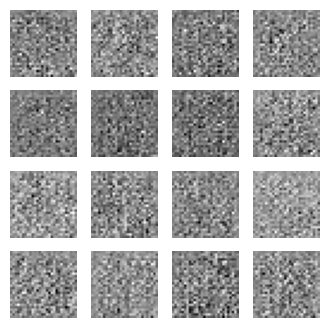

In [36]:
# 先生成第一幅、未经训练情况下的样本图片，所有的手写字符都还在随机噪点状态
generate_and_save_images(model, 0, random_vector_for_generation)

Epoch: 10, Test set ELBO: -120.24667358398438, time elapse for current epoch 97.06266641616821


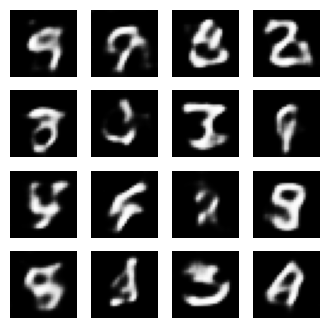

Epoch: 20, Test set ELBO: -112.93391418457031, time elapse for current epoch 91.71886324882507


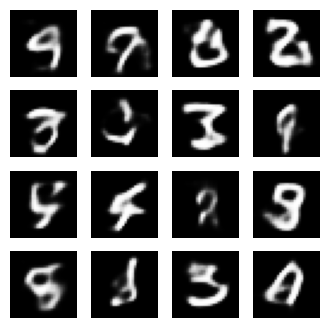

Epoch: 30, Test set ELBO: -110.06641387939453, time elapse for current epoch 98.63007164001465


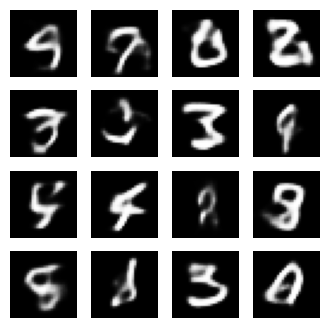

Epoch: 40, Test set ELBO: -108.4175033569336, time elapse for current epoch 96.92495250701904


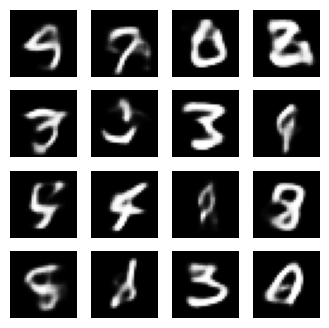

Epoch: 50, Test set ELBO: -107.1290054321289, time elapse for current epoch 90.520024061203


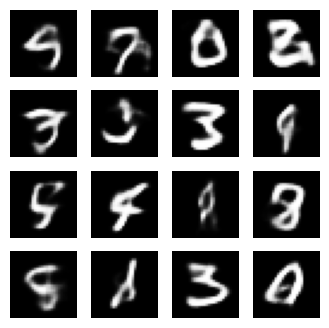

Epoch: 60, Test set ELBO: -106.00585174560547, time elapse for current epoch 105.62435603141785


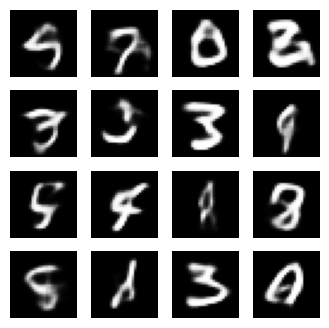

Epoch: 70, Test set ELBO: -105.36267852783203, time elapse for current epoch 100.24224209785461


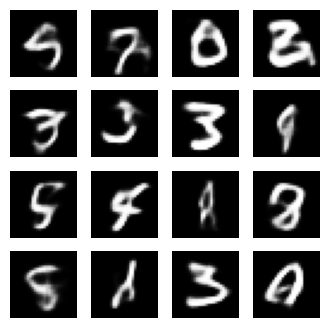

Epoch: 80, Test set ELBO: -104.60247039794922, time elapse for current epoch 102.92404437065125


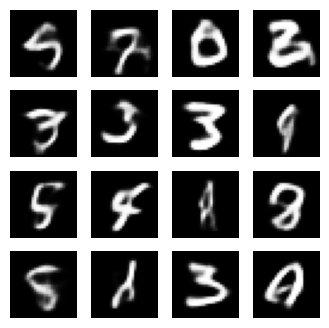

Epoch: 90, Test set ELBO: -104.1955795288086, time elapse for current epoch 97.09696674346924


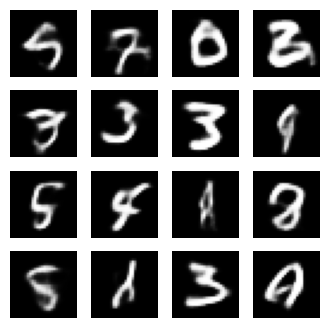

Epoch: 100, Test set ELBO: -103.81106567382812, time elapse for current epoch 101.51145267486572


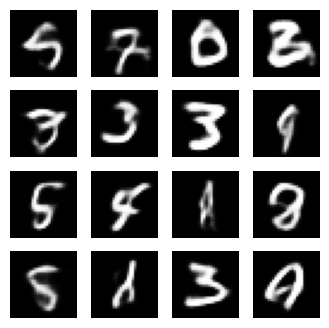

In [37]:
# 训练循环
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        # 训练一个批次
        gradients, loss = compute_gradients(model, train_x)
        apply_gradients(optimizer, gradients, model.trainable_variables)
    end_time = time.time()

    # 每10次循环生成一张图片和显示一次模型信息
    if epoch % 10 == 0:
        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            loss(compute_loss(model, test_x))
        elbo = -loss.result()
        # 显示迭代次数、损失值、和本次迭代循环耗时
        print("============================")
        print(
            'Epoch: {}, Test set ELBO: {}, '
            'time elapse for current epoch {}'.format(
                epoch,
                elbo,
                end_time - start_time))
        # 生成一张图片保存起来
        generate_and_save_images(
            model, epoch, random_vector_for_generation)

#### 结果分析

图像噪声是图像在获取或是传输过程中受到随机信号干扰，妨碍人们对图像理解及分析处理的信号。噪声会使图像失真。

在图像传播过程中，出现噪声是正常现象，模仿实际过程可能出现的噪声，使本次实验对VAE的分析有实际意义。

高斯噪声(Gaussian noise)是指它的概率密度函数服从高斯分布的一类噪声。

从结果可以看出，加了高斯噪声以后，生成的手写数字清晰度较原来差，这是必然的，因为用来学习的数据已经一定程度上失真了，所以学习结果较差。
但结果是仍然可以生成类似的手写数字图片，说明VAE有一定的抵抗噪声的能力，在原始数据失真的情况下，仍有不错的学习效果。

### 高级要求(2)-GAN

In [50]:
# 数据
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('MNIST_data/')

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [65]:
# 导入需要的包
import os                         #读取路径下文件
import shutil                     #递归删除文件
#import tensorflow as tf           #编写神经网络
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np                #矩阵运算操作
from skimage.io import imsave     #保存影像
from tensorflow.examples.tutorials.mnist import input_data  #第一次下载数据时用
 
# 图像的size为(28, 28, 1)
image_height = 28           
image_width = 28
image_size = image_height * image_width
 
# 是否训练和存储设置
train = True
restore = False              #是否存储训练结果
output_path = "./output/"    #存储文件的路径
 
# 实验所需的超参数
max_epoch = 500
batch_size = 256
h1_size = 256         #第一隐藏层的size，即特征数
h2_size = 512         #第二隐藏层的size，即特征数
z_size = 128          #生成器的传入参数

Instructions for updating:
non-resource variables are not supported in the long term


In [67]:
# 定义load_data()函数以读取数据
def load_data(data_path):
    '''
    函数功能：导出MNIST数据
    输入: data_path   传入数据所在路径（解压后的数据）
    输出: train_data  输出data，形状为(60000, 28, 28, 1)    
         train_label  输出label，形状为(60000, 1)                 
    '''
 
    f_data = open(os.path.join(data_path, 'train-images.idx3-ubyte'))
    loaded_data = np.fromfile(file=f_data, dtype=np.uint8)
    #前16个字符为说明符，需要跳过
    train_data = loaded_data[16:].reshape((-1, 784)).astype(np.float)
 
    f_label = open(os.path.join(data_path, 'train-labels.idx1-ubyte'))
    loaded_label = np.fromfile(file=f_label, dtype=np.uint8)
    #前8个字符为说明符，需要跳过
    train_label = loaded_label[8:].reshape((-1)).astype(np.float)
 
    return train_data, train_label

In [68]:
#定义GAN的生成器
def generator(z_prior):
    '''
    函数功能：生成影像，参与训练过程
    输入：z_prior,       #输入tf格式，size为（batch_size, z_size）的数据
    输出：x_generate,    #生成图像
         g_params,      #生成图像的所有参数
    '''
    # 第一个链接层 
    #以2倍标准差stddev的截断的正态分布中生成大小为[z_size, h1_size]的随机值，权值weight初始化。
    w1 = tf.Variable(tf.truncated_normal([z_size, h1_size], stddev=0.1), name="g_w1", dtype=tf.float32)
    #生成大小为[h1_size]的0值矩阵，偏置bias初始化
    b1 = tf.Variable(tf.zeros([h1_size]), name="g_b1", dtype=tf.float32)
    #通过矩阵运算，将输入z_prior传入隐含层h1。激活函数为relu
    h1 = tf.nn.relu(tf.matmul(z_prior, w1) + b1)
 
    # 第二个链接层 
    #以2倍标准差stddev的截断的正态分布中生成大小为[h1_size, h2_size]的随机值，权值weight初始化。
    w2 = tf.Variable(tf.truncated_normal([h1_size, h2_size], stddev=0.1), name="g_w2", dtype=tf.float32)
    #生成大小为[h2_size]的0值矩阵，偏置bias初始化
    b2 = tf.Variable(tf.zeros([h2_size]), name="g_b2", dtype=tf.float32)
    #通过矩阵运算，将h1传入隐含层h2。激活函数为relu
    h2 = tf.nn.relu(tf.matmul(h1, w2) + b2)
 
    # 第三个链接层 
    #以2倍标准差stddev的截断的正态分布中生成大小为[h2_size, image_size]的随机值，权值weight初始化。
    w3 = tf.Variable(tf.truncated_normal([h2_size, image_size], stddev=0.1), name="g_w3", dtype=tf.float32)
    #生成大小为[image_size]的0值矩阵，偏置bias初始化
    b3 = tf.Variable(tf.zeros([image_size]), name="g_b3", dtype=tf.float32)
    #通过矩阵运算，将h2传入隐含层h3。
    h3 = tf.matmul(h2, w3) + b3
    #利用tanh激活函数，将h3传入输出层
    x_generate = tf.nn.tanh(h3)
 
    #将所有参数合并到一起
    g_params = [w1, b1, w2, b2, w3, b3]
 
    return x_generate, g_params

In [69]:
# 定义GAN的判别器 
def discriminator(x_data, x_generated, keep_prob):
    '''
    函数功能：对输入数据进行判断，并保存其参数
    输入：x_data,        #输入的真实数据 
        x_generated,     #生成器生成的虚假数据
        keep_prob，      #dropout率，防止过拟合
    输出：y_data,        #判别器对batch个数据的处理结果
        y_generated,     #判别器对余下数据的处理结果
        d_params，       #判别器的参数
    '''
 
    # 合并输入数据，包括真实数据x_data和生成器生成的假数据x_generated
    x_in = tf.concat([x_data, x_generated], 0) 
 
    # 第一个链接层
    #以2倍标准差stddev的截断的正态分布中生成大小为[image_size, h2_size]的随机值，权值weight初始化。
    w1 = tf.Variable(tf.truncated_normal([image_size, h2_size], stddev=0.1), name="d_w1", dtype=tf.float32)
    #生成大小为[h2_size]的0值矩阵，偏置bias初始化
    b1 = tf.Variable(tf.zeros([h2_size]), name="d_b1", dtype=tf.float32)
    #通过矩阵运算，将输入x_in传入隐含层h1.同时以一定的dropout率舍弃节点，防止过拟合
    h1 = tf.nn.dropout(tf.nn.relu(tf.matmul(x_in, w1) + b1), keep_prob)
 
    # 第二个链接层
    #以2倍标准差stddev的截断的正态分布中生成大小为[h2_size, h1_size]的随机值，权值weight初始化。
    w2 = tf.Variable(tf.truncated_normal([h2_size, h1_size], stddev=0.1), name="d_w2", dtype=tf.float32)
    #生成大小为[h1_size]的0值矩阵，偏置bias初始化
    b2 = tf.Variable(tf.zeros([h1_size]), name="d_b2", dtype=tf.float32)
    #通过矩阵运算，将h1传入隐含层h2.同时以一定的dropout率舍弃节点，防止过拟合
    h2 = tf.nn.dropout(tf.nn.relu(tf.matmul(h1, w2) + b2), keep_prob)
 
    # 第三个链接层
    #以2倍标准差stddev的截断的正态分布中生成大小为[h1_size, 1]的随机值，权值weight初始化。
    w3 = tf.Variable(tf.truncated_normal([h1_size, 1], stddev=0.1), name="d_w3", dtype=tf.float32)
    #生成0值，偏置bias初始化
    b3 = tf.Variable(tf.zeros([1]), name="d_b3", dtype=tf.float32)
    #通过矩阵运算，将h2传入隐含层h3
    h3 = tf.matmul(h2, w3) + b3
 
    #从h3中切出batch_size张图像
    y_data = tf.nn.sigmoid(tf.slice(h3, [0, 0], [batch_size, -1], name=None))
    #从h3中切除余下的图像
    y_generated = tf.nn.sigmoid(tf.slice(h3, [batch_size, 0], [-1, -1], name=None))
 
    #判别器的所有参数
    d_params = [w1, b1, w2, b2, w3, b3]
 
    return y_data, y_generated, d_params

In [70]:
#显示结果的函数
def show_result(batch_res, fname, grid_size=(8, 8), grid_pad=5):
    '''
    函数功能：输入相关参数，将运行结果以图片的形式保存到当前路径下
    输入：batch_res,       #输入数据
        fname,             #输入路径
        grid_size=(8, 8),  #默认输出图像为8*8张
        grid_pad=5，       #默认图像的边缘留白为5像素
    输出：无
    '''
    
    #将batch_res进行值[0, 1]归一化，同时将其reshape成（batch_size, image_height, image_width）
    batch_res = 0.5 * batch_res.reshape((batch_res.shape[0], image_height, image_width)) + 0.5
    #重构显示图像格网的参数
    img_h, img_w = batch_res.shape[1], batch_res.shape[2]
    grid_h = img_h * grid_size[0] + grid_pad * (grid_size[0] - 1)
    grid_w = img_w * grid_size[1] + grid_pad * (grid_size[1] - 1)
    img_grid = np.zeros((grid_h, grid_w), dtype=np.uint8)
    for i, res in enumerate(batch_res):
        if i >= grid_size[0] * grid_size[1]:
            break
        img = (res) * 255.
        img = img.astype(np.uint8)
        row = (i // grid_size[0]) * (img_h + grid_pad)
        col = (i % grid_size[1]) * (img_w + grid_pad)
        img_grid[row:row + img_h, col:col + img_w] = img
    #保存图像
    imsave(fname, img_grid)

In [71]:
# 定义训练过程
def train():
    '''
    函数功能：训练整个GAN网络，并随机生成手写数字
    输入：无
    输出：sess.saver()
    '''
 
    # 加载数据
    train_data, train_label = load_data("MNIST_data")
    size = train_data.shape[0]
 
    # 构建模型---------------------------------------------------------------------
    # 定义GAN网络的输入，其中x_data为[batch_size, image_size], z_prior为[batch_size, z_size]
    x_data = tf.placeholder(tf.float32, [batch_size, image_size], name="x_data") # (batch_size, image_size)
    z_prior = tf.placeholder(tf.float32, [batch_size, z_size], name="z_prior") # (batch_size, z_size)
    # 定义dropout率
    keep_prob = tf.placeholder(tf.float32, name="keep_prob") 
    global_step = tf.Variable(0, name="global_step", trainable=False)
 
    # 利用生成器生成数据x_generated和参数g_params
    x_generated, g_params = generator(z_prior)
    # 利用判别器判别生成器的结果
    y_data, y_generated, d_params = discriminator(x_data, x_generated, keep_prob)
 
    # 定义判别器和生成器的loss函数
    d_loss = - (tf.log(y_data) + tf.log(1 - y_generated))
    g_loss = - tf.log(y_generated)
 
    # 设置学习率为0.0001，用AdamOptimizer进行优化
    optimizer = tf.train.AdamOptimizer(0.0001)
 
    # 判别器discriminator 和生成器 generator 对损失函数进行最小化处理
    d_trainer = optimizer.minimize(d_loss, var_list=d_params)
    g_trainer = optimizer.minimize(g_loss, var_list=g_params)
    # 模型构建完毕--------------------------------------------------------------------
 
    # 全局变量初始化
    init = tf.global_variables_initializer()
 
    # 启动会话sess
    saver = tf.train.Saver()
    sess = tf.Session()
    sess.run(init)
 
    # 判断是否需要存储
    if restore:
        #若是，将最近一次的checkpoint点存到outpath下
        chkpt_fname = tf.train.latest_checkpoint(output_path)
        saver.restore(sess, chkpt_fname)
    else:
        #若否，判断目录是存在，如果目录存在，则递归的删除目录下的所有内容，并重新建立目录
        if os.path.exists(output_path):
            shutil.rmtree(output_path)
        os.mkdir(output_path)
 
    # 利用随机正态分布产生噪声影像，尺寸为(batch_size, z_size)
    z_sample_val = np.random.normal(0, 1, size=(batch_size, z_size)).astype(np.float32)
 
    # 逐个epoch内训练
    for i in range(sess.run(global_step), max_epoch):
        # 图像每个epoch内可以放(size // batch_size)个size
        for j in range(size // batch_size):
            if j%20 == 0:
                #print("epoch:%s, iter:%s" % (i, j))
            
            # 训练一个batch的数据
            batch_end = j * batch_size + batch_size
            if batch_end >= size:
                batch_end = size - 1
            x_value = train_data[ j * batch_size : batch_end ]
            # 将数据归一化到[-1, 1]
            x_value = x_value / 255.
            x_value = 2 * x_value - 1
            
            # 以正太分布的形式产生随机噪声
            z_value = np.random.normal(0, 1, size=(batch_size, z_size)).astype(np.float32)
            # 每个batch下，输入数据运行GAN，训练判别器
            sess.run(d_trainer,
                     feed_dict={x_data: x_value, z_prior: z_value, keep_prob: np.sum(0.7).astype(np.float32)})
            # 每个batch下，输入数据运行GAN，训练生成器
            if j % 1 == 0:
                sess.run(g_trainer,
                         feed_dict={x_data: x_value, z_prior: z_value, keep_prob: np.sum(0.7).astype(np.float32)})
        # 每一个epoch中的所有batch训练完后，利用z_sample测试训练后的生成器
        x_gen_val = sess.run(x_generated, feed_dict={z_prior: z_sample_val})
        # 每一个epoch中的所有batch训练完后，显示生成器的结果，并打印生成结果的值
        show_result(x_gen_val, os.path.join(output_path, "sample%s.jpg" % i))
        print(x_gen_val)
        # 每一个epoch中，生成随机分布以重置z_random_sample_val
        z_random_sample_val = np.random.normal(0, 1, size=(batch_size, z_size)).astype(np.float32)
        # 每一个epoch中，利用z_random_sample_val生成手写数字图像，并显示结果
        x_gen_val = sess.run(x_generated, feed_dict={z_prior: z_random_sample_val})
        show_result(x_gen_val, os.path.join(output_path, "random_sample%s.jpg" % i))
        # 保存会话
        sess.run(tf.assign(global_step, i + 1))
        saver.save(sess, os.path.join(output_path, "model"), global_step=global_step)

In [72]:
if __name__ == '__main__':
    if train:
        train()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


D:\Dev\Anaconda\envs\tmpenv\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
D:\Dev\Anaconda\envs\tmpenv\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


epoch:0, iter:0
epoch:0, iter:20
epoch:0, iter:40
epoch:0, iter:60
epoch:0, iter:80
epoch:0, iter:100
epoch:0, iter:120
epoch:0, iter:140
epoch:0, iter:160
epoch:0, iter:180
epoch:0, iter:200
epoch:0, iter:220
[[-0.99964225 -0.9996327  -0.8671087  ... -0.99690044 -0.9254835
  -0.9999791 ]
 [-0.9994858  -0.9925853  -0.8700929  ... -0.99775827 -0.988821
  -0.9997016 ]
 [-0.9806738  -0.9690047  -0.75255895 ... -0.9978472  -0.98747045
  -0.99965835]
 ...
 [-0.99993724 -0.9725471  -0.9919518  ... -0.9953535  -0.9989368
  -0.99827975]
 [-0.99985933 -0.9882372  -0.8636944  ... -0.89732504 -0.9990877
  -0.9996964 ]
 [-0.9981175  -0.9916862  -0.9355074  ... -0.71257025 -0.98204917
  -0.9989305 ]]
epoch:1, iter:0
epoch:1, iter:20
epoch:1, iter:40
epoch:1, iter:60
epoch:1, iter:80
epoch:1, iter:100
epoch:1, iter:120
epoch:1, iter:140
epoch:1, iter:160
epoch:1, iter:180
epoch:1, iter:200
epoch:1, iter:220
[[-0.9999877  -0.9999826   0.9999988  ... -0.9999188  -0.99999017
   0.98310477]
 [-0.9999986

#### 结果如下：

![dfdf](7.png)

#### GAN与VAE对比
通过GAN结果与VAE结果进行比对可以发现，两者训练出的图像清晰度有较明显的差异：GAN对抗网络的生成图像会更优于VAE模型。
<br>
因此对结果进行细致分析，区别两种模型的不同：
* 训练方式：VAE使用反向传播和随机梯度下降来训练编码器和解码器，而GAN使用生成器和判别器之间的对抗性训练；
* 网络结构：VAE由编码器和解码器组成，而GAN由生成器和判别器组成；
* 模型复杂度：VAE使用变分推理来学习潜在变量的分布，因此可能更加复杂。GAN可能更加简单，但需要更多训练数据；
* 生成图像质量：VAE生成的图像可能不够清晰，因为在生成图像时，编码器和解码器之间存在噪声。GAN生成的图像可能更加清晰；

#### GAN与VAE结合
除此以外，可以考虑将GAN与VAE生成模型相结合，取长补短生成高精度图像。
<br>
下面提出几种结合方法：
* 第一种：使用VAE的隐空间作为GAN的输入。在这种情况下，VAE负责学习隐空间的分布，而GAN负责生成高质量的图像；
* 第二种：使用GAN的生成器来初始化VAE的解码器。在这种情况下，GAN学习高质量的图像，并将其用于初始化VAE的解码器；
* 以上两种方案都可以实现将VAE的隐空间学习能力与GAN的图像生成能力的优势相结合。